FROM: https://bpostance.github.io/posts/clustering-mixed-data/

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [59]:
df = pd.read_csv("datasets/car_insurance_claim.csv")

for col in ["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM", "CLM_AMT",]:
    df[col] = df[col].replace("[^.0-9]", "", regex=True).astype(float).fillna(0.0)

for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.upper().replace("Z_", "", regex=True).replace("[^A-Z<]", "", regex=True)

df.drop(labels=["ID","BIRTH"], axis=1, inplace=True)

df["OCCUPATION"].fillna("OTHER", inplace=True)
for col in ["AGE","YOJ","CAR_AGE"]:
    df[col].fillna(df[col].mean(), inplace=True)

for col in df.select_dtypes(include=[float]):
    df[col] = df[col].astype(int)

df["URBANICITY"] = df["URBANICITY"].map({"HIGHLYURBANURBAN":"URBAN", "HIGHLYRURALRURAL":"RURAL"})
df.rename(columns={"URBANICITY": "AREA"}, inplace=True)

categorical_features = ["CAR_USE", "REVOKED", "RED_CAR", "GENDER", "MSTATUS", "AREA", "PARENT1", "EDUCATION", "KIDSDRIV", "HOMEKIDS", "CAR_TYPE", "OCCUPATION", "CLAIM_FLAG"]
numerical_features = ["AGE", "HOMEKIDS", "YOJ", "INCOME", "HOME_VAL", "TRAVTIME", "BLUEBOOK", "TIF", "OLDCLAIM", "CLM_FREQ", "CLM_AMT", "CAR_AGE"]

df

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,AREA
0,0,60,0,11,67349,NO,0,NO,M,PHD,...,MINIVAN,YES,4461,2,NO,3,0,18,0,URBAN
1,0,43,0,11,91449,NO,257252,NO,M,HIGHSCHOOL,...,MINIVAN,YES,0,0,NO,0,0,1,0,URBAN
2,0,48,0,11,52881,NO,0,NO,M,BACHELORS,...,VAN,YES,0,0,NO,2,0,10,0,URBAN
3,0,35,1,10,16039,NO,124191,YES,F,HIGHSCHOOL,...,SUV,NO,38690,2,NO,3,0,10,0,URBAN
4,0,51,0,14,0,NO,306251,YES,M,<HIGHSCHOOL,...,MINIVAN,YES,0,0,NO,0,0,6,0,URBAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,1,45,2,9,164669,NO,386273,YES,M,PHD,...,MINIVAN,NO,0,0,NO,2,0,17,0,URBAN
10298,0,46,0,9,107204,NO,332591,YES,M,MASTERS,...,PANELTRUCK,NO,0,0,NO,0,0,1,0,URBAN
10299,0,48,0,15,39837,NO,170611,YES,F,<HIGHSCHOOL,...,SUV,NO,0,0,NO,0,0,1,0,URBAN
10300,0,50,0,7,43445,NO,149248,YES,F,BACHELORS,...,MINIVAN,NO,0,0,NO,0,0,11,0,URBAN


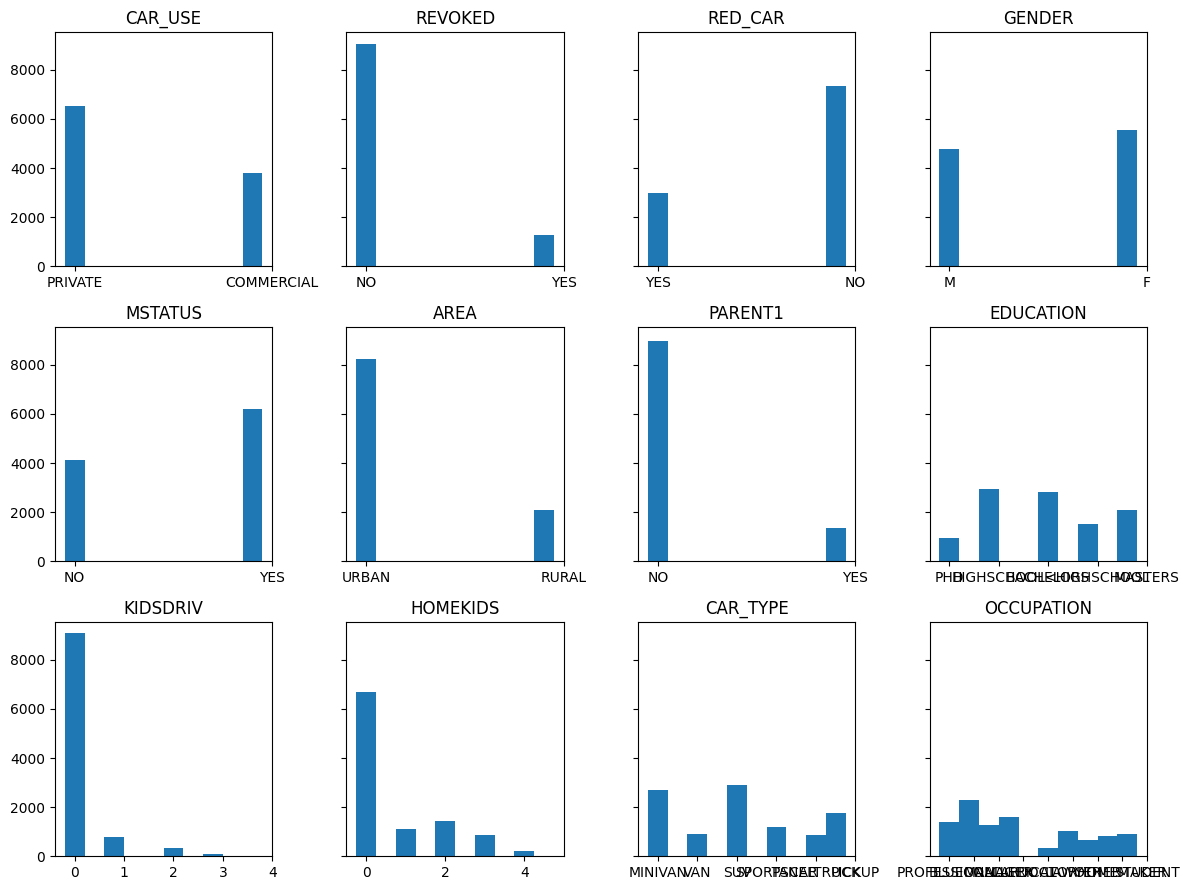

In [60]:
fig,axs = plt.subplots(3, 4, figsize=(12, 9), sharey=True)

for ax, feat in zip(axs.flatten(), categorical_features):
    ax.hist(df[feat], align="left")
    ax.set_title(feat)
plt.tight_layout()

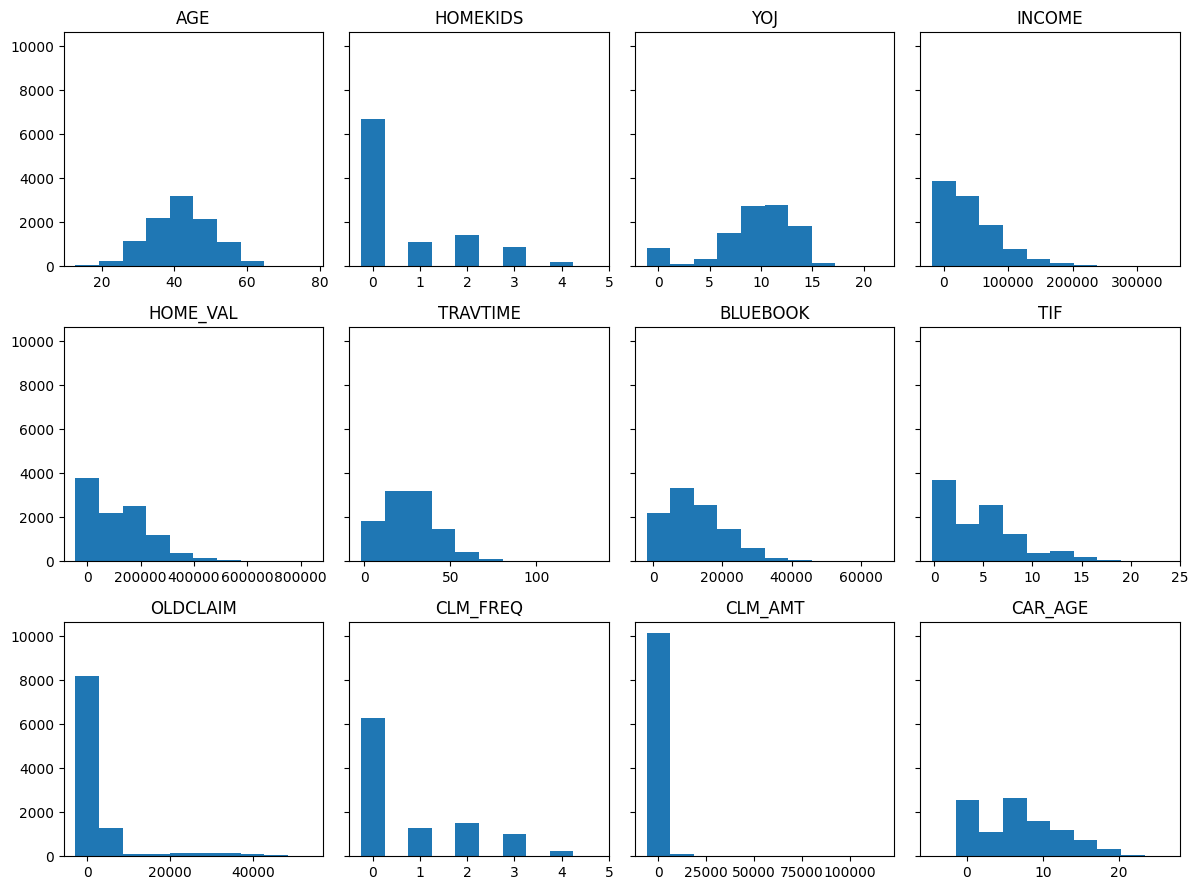

In [61]:
fig,axs = plt.subplots(3, 4, figsize=(12, 9), sharey=True)

for ax, feat in zip(axs.flatten(), numerical_features):
    ax.hist(df[feat], align="left")
    ax.set_title(feat)
plt.tight_layout()

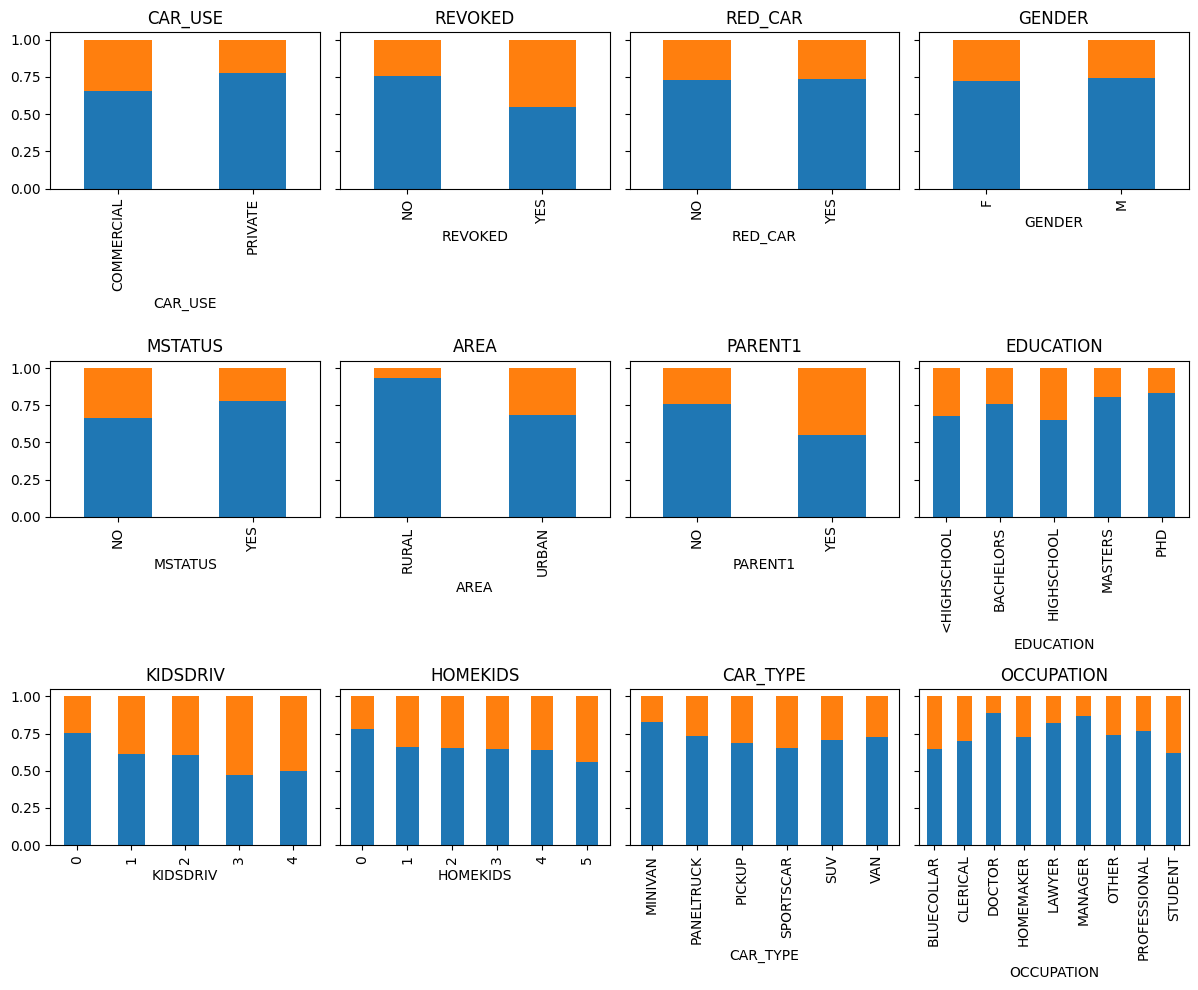

In [62]:
fig, axs = plt.subplots(3, 4, figsize=(12,10), sharey=True)

for ax,feat in zip(axs.flatten(), categorical_features):
    ((pd.crosstab(df['CLAIM_FLAG'], df[feat])) / (pd.crosstab(df['CLAIM_FLAG'], df[feat]).sum())).T.plot.bar(stacked=True, ax=ax, legend=False, title=None)
    ax.set_title(feat)
plt.tight_layout()